# EX 4: Data visualization with t-SNE and clustering with DBSCAN

### Group: Vanilla Ice-Team

    Michele Avella    mat.2024548
    Elena Leonelli    mat.2028635
    Marika Sartore    mat.2017916
    Filippo Ziliotto  mat.2017425

### Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn import manifold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1st PART : 

## 1.1 Loading the data

Dataset from 'data_t-SNE_310101_d5_R100_e1_N800.dat'

In [2]:
data_in = pd.DataFrame(np.loadtxt("DATA/data_t-SNE_310101_d5_R100_e1_N800.dat", delimiter="\t"))
data_in

,0,1,2,3,4
0,-83065.0,29521.0,68815.0,-100340.0,-29235.0
1,-110304.0,38545.0,68519.0,-115776.0,-46287.0
2,-88908.0,31418.0,69174.0,-107023.0,-30120.0
3,-99298.0,32751.0,71580.0,-113674.0,-38766.0
4,-77225.0,29431.0,64216.0,-95754.0,-28018.0
...,...,...,...,...,...
795,81024.0,53467.0,46739.0,54310.0,19020.0
796,-76420.0,-65897.0,-59331.0,-46679.0,-11939.0
797,-40830.0,-60967.0,-76134.0,-3094.0,-8516.0
798,-8663.0,34856.0,72689.0,-48530.0,-115.0


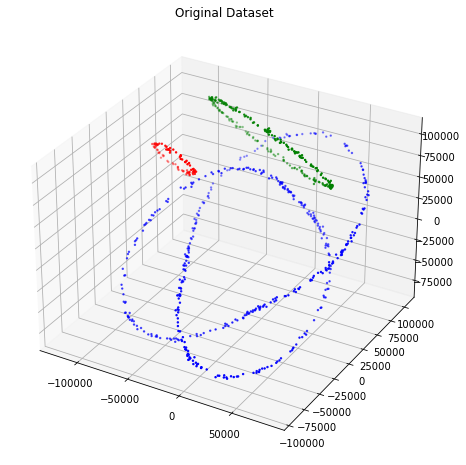

In [3]:
# 3D plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

Axes3D.scatter(self=ax,xs=data_in[:80][0], ys=data_in[:80][1],zs=data_in[:80][2], 
               zdir='z', s=2,  depthshade=True,c='red')
Axes3D.scatter(self=ax,xs=data_in[80:320][0], ys=data_in[80:320][1],zs=data_in[80:320][2], 
               zdir='z', s=2, depthshade=True,c='green')
Axes3D.scatter(self=ax,xs=data_in[320:][0], ys=data_in[320:][1],zs=data_in[320:][2], 
               zdir='z', s=2, depthshade=True,c='blue')

plt.title('Original Dataset')
plt.show()

## 1.2 t-SNE

Firstly, we use PCA procedure to reduce the dataset from 5 to 3 dimensions. The first three principal components have over $98\%$ of the total variability.\
Then we project with t-SNE into two dimensions using eight different values of perplexity.

In [4]:
# PCA to reduce the dimensionality of the dataset: from 5 dim to 3
np.random.seed(12345)
pca = PCA(n_components=3)
t = pca.fit_transform(data_in)

print("Variability of the first 3 principal components:",pca.explained_variance_ratio_)

Variability of the first 3 principal components: [0.60943749 0.33260891 0.05780895]


In [5]:
# function to apply t-SNE to the dataset
def t_SNE_2d(perp, i, j, n_comp=2, data_pca=t):
    global data_mod
    data_mod=manifold.TSNE(n_components=n_comp,perplexity=perp, random_state=123).fit_transform(t)
    rosso=data_mod[:80]
    verde=data_mod[80:320]
    blu=data_mod[320:]
    
    
    return (axs[i,j].scatter(rosso[:,0], rosso[:,1], s=2, c='red',marker='o'),
            axs[i,j].scatter(verde[:,0], verde[:,1], s=2, c='green',marker='o'),
            axs[i,j].scatter(blu[:,0], blu[:,1], s=2, c='blue',marker='o'),
            axs[i,j].set_title('{} perplexity'.format(perp)))


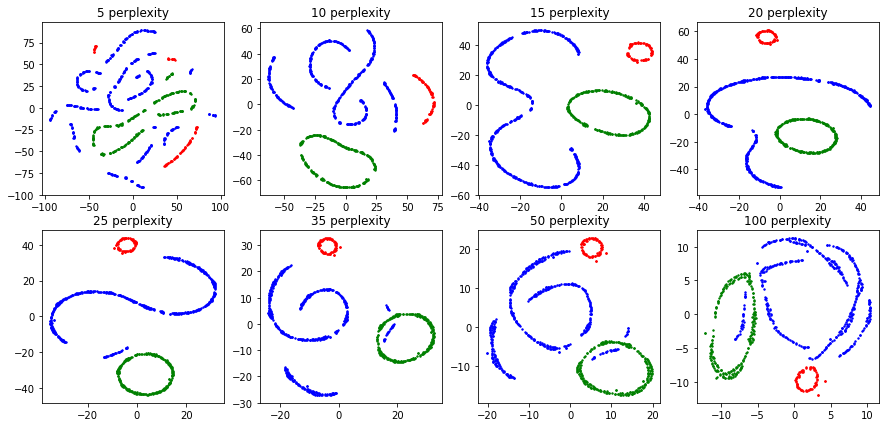

In [33]:
# plots with different perplexities
fig, axs = plt.subplots(2,4,figsize=(15,7))

t_SNE_2d(5,0,0)
t_SNE_2d(10,0,1)
t_SNE_2d(15,0,2)
t_SNE_2d(20,0,3)
t_SNE_2d(25,1,0)
t_SNE_2d(35,1,1)
t_SNE_2d(50,1,2)
t_SNE_2d(100,1,3)

plt.show()

We can see that the best value of perplexity that permits to distinguish the different clusters is around $15$.

## 1.3 DBSCAN

Now we use the DBSCAN algorithm on the PCA-data with and without t-SNE.

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from collections import OrderedDict

In [8]:
# useful functions

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

def NMI(y_true, y_pred):
    # Normalized mutual information function
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)


cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6","#A30059", "#0000A6", 
            "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693",
            "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", 
            "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

def plotting_ax(X, y, ax):
    # Plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

To find a good range for the cutoffs “eps” in DBSCAN, we sort all the minimum distances to first neighbors and we plot them.

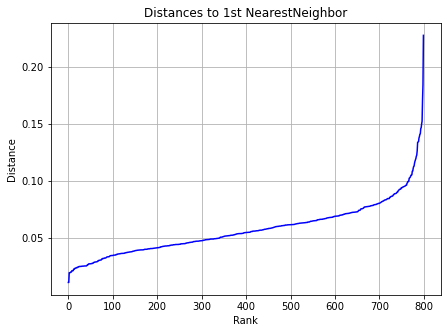

In [39]:
# compute the distance between NearestNeighbors

X1 = StandardScaler().fit_transform(data_in)
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X1)
distances, indices = nbrs.kneighbors(X1)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(7,5))
plt.title('Distances to 1st NearestNeighbor')
plt.xlabel('Rank')
plt.ylabel('Distance')
plt.plot(distances,'b')
plt.grid()
plt.show()

The good value are the ones multiple of the max curvature: so in our case we are going to use multiples of 0.1.

### with t-SNE

In [41]:
# preparing the data
np.random.seed(12345)

#PCA
pca = PCA(n_components=3)
t = pca.fit_transform(data_in)

#t-SNE
X = manifold.TSNE(n_components=2,perplexity=15, random_state=123).fit_transform(t)

#scale
X = StandardScaler().fit_transform(X)

#labels
ytrue = np.zeros(len(data_in)).astype(float) #labels 0=red, 1=green, 2=blue
ytrue[80:320] = 1
ytrue[320:] = 2

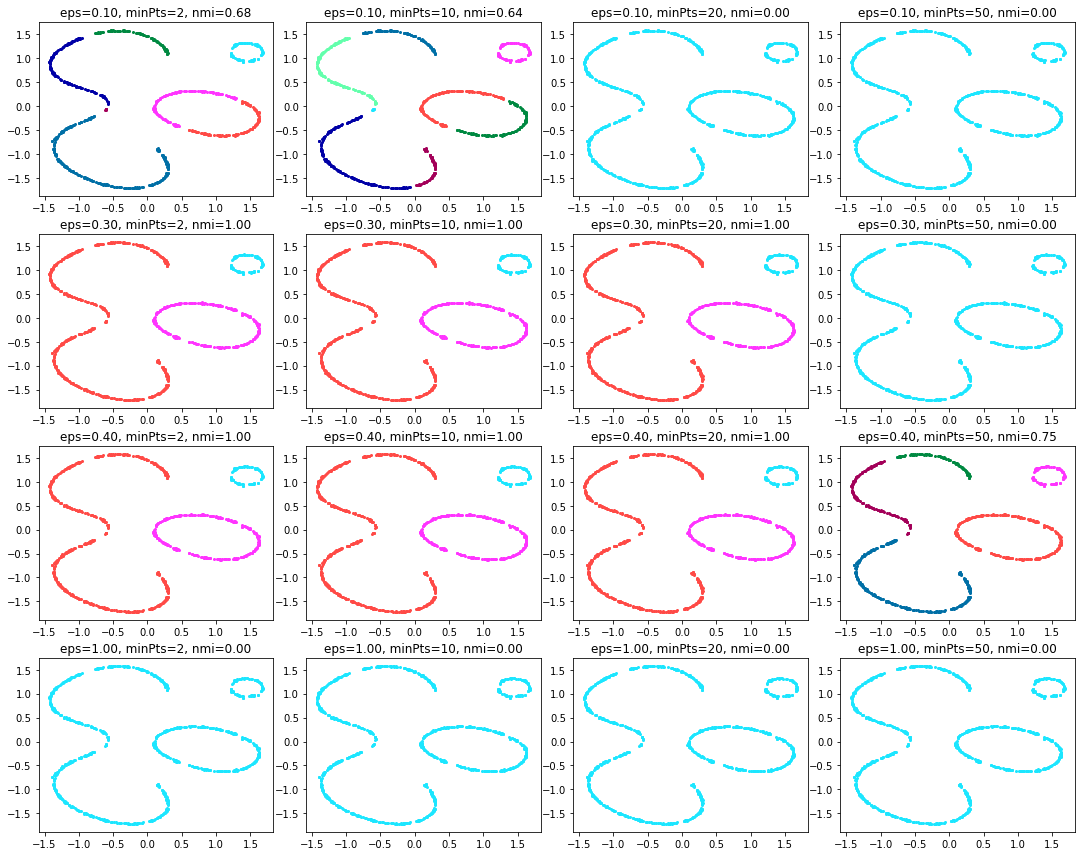

In [42]:
# DBSCAN, results with different eps and min_sample
eps_range = [0.1,0.3,0.4,1]
min_sample_range = [2,10,20,50]

fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,12))

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi = NMI(ytrue,y) 
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()

From the plots above, we can see that out of the range $[0.3,0.4] eps$ the subdivision into cluster is wrong: out of this range DBSCAN finds too many clusters or it groups all data into one cluster. \
In this case, the best values for the minimum number of points are 2,10,20.

### without t-SNE

In [43]:
# scale the data
X1 = data_in
X1 = StandardScaler().fit_transform(X1)
ytrue = np.zeros(len(data_in)).astype(float) #labels 0=red, 1=green, 2=blue
ytrue[80:320] = 1
ytrue[320:] = 2


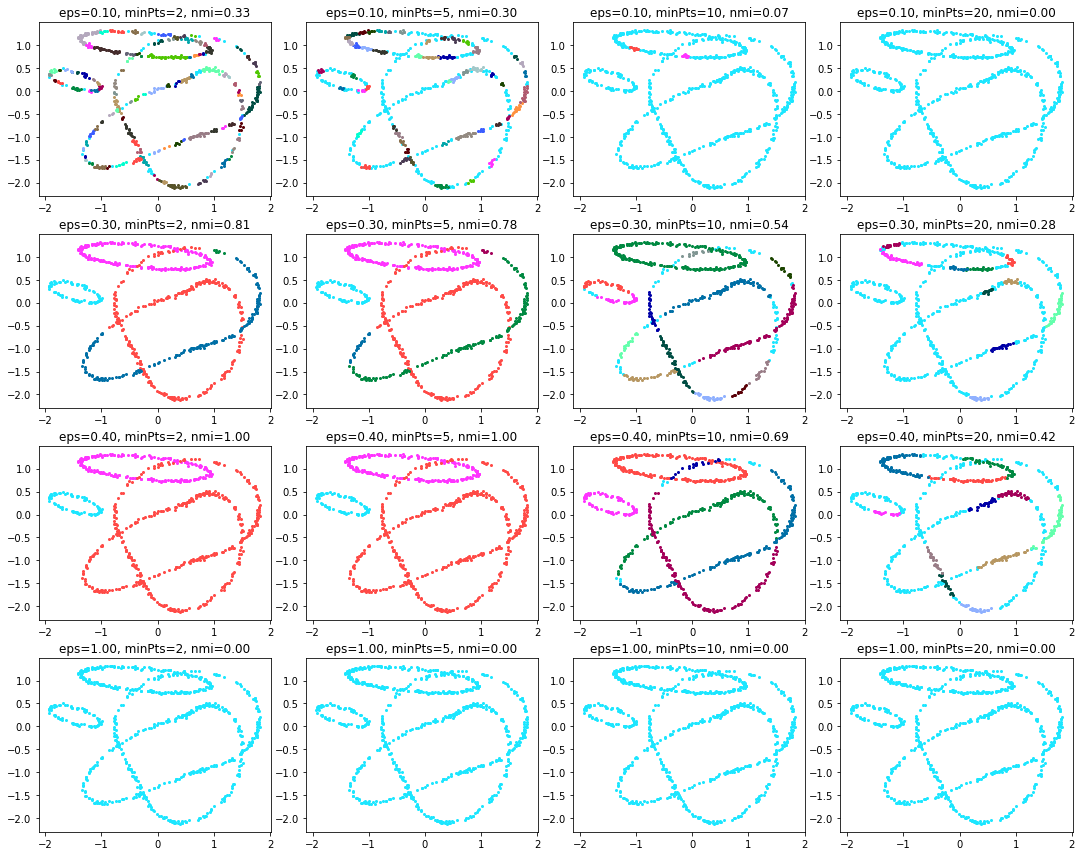

In [44]:
# DBSCAN, results with different eps and min_sample
eps_range = [0.1,0.3,0.4,1]
min_sample_range = [2,5,10,20]

fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,12))

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X1)
        y = model.labels_
        plotting_ax(X1,y,ax[i,j])
        nmi = NMI(ytrue,y) 
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()

Looking at the results without t-SNE before DBSCAN, the best eps value is $0.4$ and the best numbers of minPts are $2$ and $5$.

In the end, we can say that with this dataset the performaces of DBSCAN on t-SNE + PCA data and on the original data are equally good. In both cases DBSCAN is able to reach $nmi = 1$ and this means that all the predicted labels are true.

# 2nd PART:

## 2.1 Loading the data

Dataset from 'x_M5_N400.csv' and 'y_M5_N400.csv'

In [76]:
x = np.loadtxt('DATA/x_M5_N400.csv', delimiter=' ')
y = np.loadtxt('DATA/y_M5_N400.csv')

print('Dataset:\n',x,'\n')
print('Labels:\n',y,'\n')
print('x.shape =',x.shape,'y.shape =',y.shape)

Dataset:
 [[0. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 1.]] 

Labels:
 [1. 3. 2. 3. 2. 4. 3. 1. 4. 0. 3. 4. 0. 3. 4. 1. 4. 3. 1. 3. 2. 2. 0. 3.
 4. 3. 2. 2. 3. 2. 1. 2. 0. 1. 2. 0. 0. 4. 1. 4. 4. 0. 3. 0. 1. 4. 3. 3.
 2. 3. 4. 0. 0. 4. 4. 4. 4. 3. 4. 2. 3. 3. 1. 1. 4. 2. 4. 0. 0. 3. 2. 2.
 3. 2. 0. 1. 0. 2. 3. 2. 0. 2. 4. 0. 4. 2. 1. 3. 1. 0. 0. 3. 3. 1. 4. 4.
 2. 2. 0. 0. 3. 1. 0. 0. 4. 3. 1. 4. 1. 0. 1. 0. 0. 1. 0. 3. 2. 4. 2. 0.
 2. 4. 1. 3. 0. 4. 0. 2. 3. 2. 2. 1. 2. 2. 2. 0. 0. 1. 2. 3. 4. 2. 4. 4.
 0. 3. 3. 0. 1. 0. 0. 0. 4. 4. 3. 4. 2. 3. 1. 1. 1. 0. 0. 1. 3. 1. 3. 1.
 4. 4. 0. 3. 0. 4. 4. 1. 0. 1. 2. 3. 1. 1. 3. 2. 2. 2. 3. 4. 3. 0. 0. 2.
 3. 3. 0. 2. 3. 0. 3. 3. 4. 4. 4. 3. 4. 0. 3. 1. 4. 1. 3. 3. 4. 4. 4. 0.
 3. 4. 0. 1. 2. 2. 1. 3. 1. 4. 4. 3. 4. 4. 2. 3. 1. 1. 1. 3. 3. 1. 0. 1.
 0. 4. 2. 2. 0. 2. 3. 0. 3. 2. 3. 4. 1. 3. 1. 0. 1. 3. 4. 2. 1. 2. 0. 0.
 2. 2. 3. 2. 0. 2. 0

In [50]:
#PCA keeping 36 comp
pca = PCA(n_components=36)
x_pca = pca.fit_transform(x)

print("Variability of the components:\n",pca.explained_variance_ratio_)

Variability of the components:
 [0.12935663 0.09174013 0.06816439 0.04481825 0.03855468 0.03738866
 0.03455835 0.03345242 0.03074126 0.02965202 0.02821174 0.02725704
 0.02694979 0.02543062 0.02460923 0.0240095  0.02291788 0.02217369
 0.02188693 0.0197375  0.01963921 0.0188256  0.01766569 0.01726113
 0.01661244 0.01539566 0.01476161 0.01424017 0.01364787 0.0130719
 0.01184375 0.0109913  0.01042702 0.00949128 0.00842828 0.00608637]


## 2.2 t-SNE


We project with t-SNE in two dimensions using six different values of perplexity.

In [15]:
def t_sne(perp, i,j ,comp=2, data=x):
    
    np.random.seed(123)
    x_t = manifold.TSNE(n_components=comp, perplexity=perp).fit_transform(x)
    
    df = pd.DataFrame({'x1' : x_t[:,0], 'x2' : x_t[:,1], 'y'  : y})
    df0 = df[df['y']==0]
    df1 = df[df['y']==1]
    df2 = df[df['y']==2]
    df3 = df[df['y']==3]
    df4 = df[df['y']==4]
    
    axs[i,j].plot(df0['x1'], df0['x2'],'bo',label='lab 0')
    axs[i,j].plot(df1['x1'], df1['x2'],'ro',label='lab 1') 
    axs[i,j].plot(df2['x1'], df2['x2'],'go',label='lab 2')
    axs[i,j].plot(df3['x1'], df3['x2'],'ko',label='lab 3')
    axs[i,j].plot(df4['x1'], df4['x2'],'yo',label='lab 4')
    axs[i,j].legend()
    axs[i,j].set_title('{} perplexity'.format(perp))
    


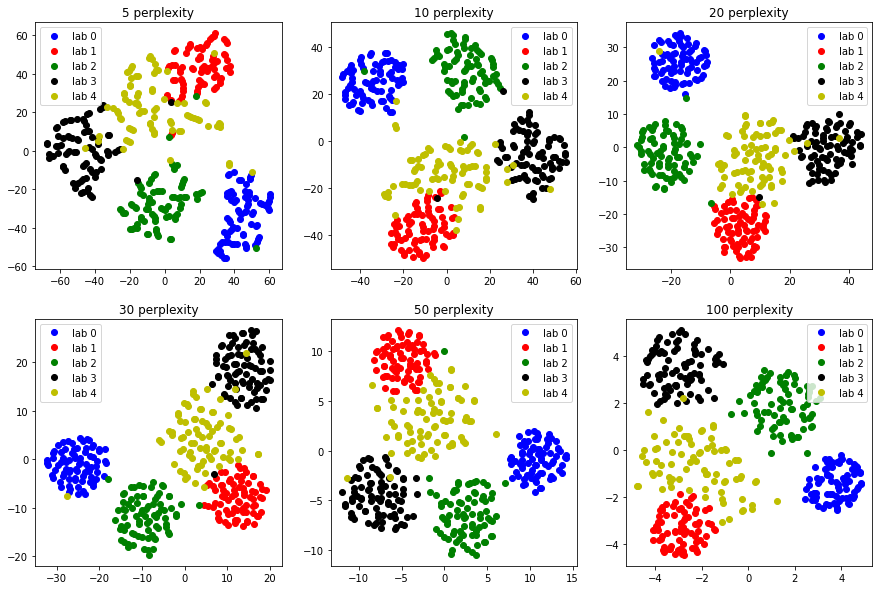

In [16]:
# results using orginal data
np.random.seed(123)

fig, axs=plt.subplots(2,3,figsize=(15,10))

t_sne(5,0,0)
t_sne(10,0,1)
t_sne(20,0,2)
t_sne(30,1,0)
t_sne(50,1,1)
t_sne(100,1,2)

Visually, the best perplexities are $30$ and $50$.

Points for y=1 (red) are close to those with y=4 (yellow), and this can be due to the fact that in the original space the samples with these labels are very similar and close to each others.

Now we repeat the same procedure but before using t-SNE we apply the PCA leaving all the 36 dimensions, in order to rotate the original data.

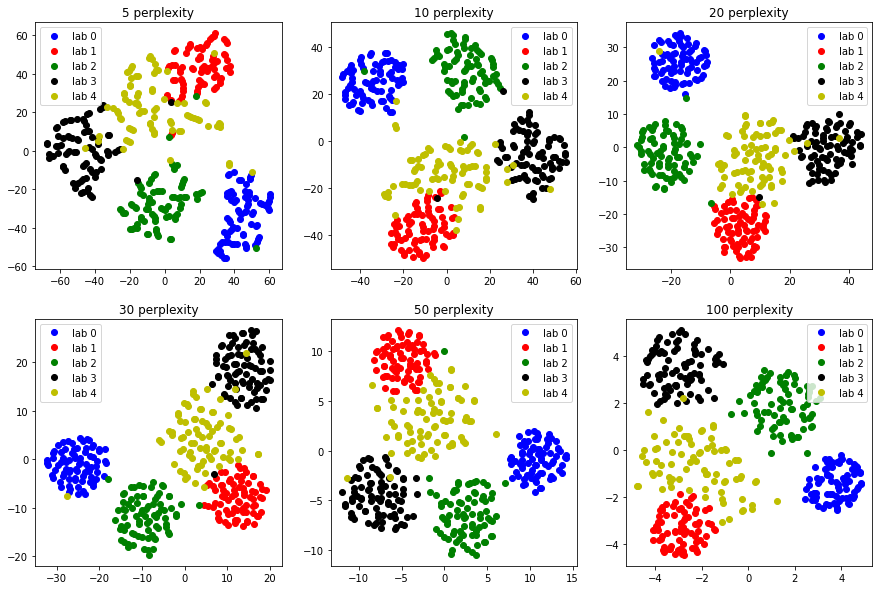

In [17]:
# results using PCA data
np.random.seed(123)

fig, axs=plt.subplots(2,3,figsize=(15,10))

t_sne(5,0,0,data=x_pca)
t_sne(10,0,1,data=x_pca)
t_sne(20,0,2,data=x_pca)
t_sne(30,1,0,data=x_pca)
t_sne(50,1,1,data=x_pca)
t_sne(100,1,2,data=x_pca)

The results are very similar to the ones obtained before in the case without PCA.

## 2.3 DBSCAN

### DBSCAN applied to original data (36-dim)

Firstly we try to apply DBSCAN to the origial 36dim dataset:

In [56]:
# function to make just one plot
def plotting(X, y,s=4):
    # Plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        plt.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=s, label=yu)
        plt.title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_sample,nmi))
    plt.legend()
    plt.show()  

True labels =
 [1. 3. 2. 3. 2. 4. 3. 1. 4. 0. 3. 4. 0. 3. 4. 1. 4. 3. 1. 3. 2. 2. 0. 3.
 4. 3. 2. 2. 3. 2. 1. 2. 0. 1. 2. 0. 0. 4. 1. 4. 4. 0. 3. 0. 1. 4. 3. 3.
 2. 3. 4. 0. 0. 4. 4. 4. 4. 3. 4. 2. 3. 3. 1. 1. 4. 2. 4. 0. 0. 3. 2. 2.
 3. 2. 0. 1. 0. 2. 3. 2. 0. 2. 4. 0. 4. 2. 1. 3. 1. 0. 0. 3. 3. 1. 4. 4.
 2. 2. 0. 0. 3. 1. 0. 0. 4. 3. 1. 4. 1. 0. 1. 0. 0. 1. 0. 3. 2. 4. 2. 0.
 2. 4. 1. 3. 0. 4. 0. 2. 3. 2. 2. 1. 2. 2. 2. 0. 0. 1. 2. 3. 4. 2. 4. 4.
 0. 3. 3. 0. 1. 0. 0. 0. 4. 4. 3. 4. 2. 3. 1. 1. 1. 0. 0. 1. 3. 1. 3. 1.
 4. 4. 0. 3. 0. 4. 4. 1. 0. 1. 2. 3. 1. 1. 3. 2. 2. 2. 3. 4. 3. 0. 0. 2.
 3. 3. 0. 2. 3. 0. 3. 3. 4. 4. 4. 3. 4. 0. 3. 1. 4. 1. 3. 3. 4. 4. 4. 0.
 3. 4. 0. 1. 2. 2. 1. 3. 1. 4. 4. 3. 4. 4. 2. 3. 1. 1. 1. 3. 3. 1. 0. 1.
 0. 4. 2. 2. 0. 2. 3. 0. 3. 2. 3. 4. 1. 3. 1. 0. 1. 3. 4. 2. 1. 2. 0. 0.
 2. 2. 3. 2. 0. 2. 0. 3. 1. 0. 4. 3. 4. 4. 4. 1. 0. 2. 3. 4. 2. 3. 1. 0.
 3. 1. 2. 4. 2. 1. 4. 0. 1. 4. 2. 1. 4. 2. 2. 1. 4. 3. 3. 0. 1. 3. 2. 2.
 1. 0. 1. 4. 3. 2. 2. 3. 0. 2. 2. 3.

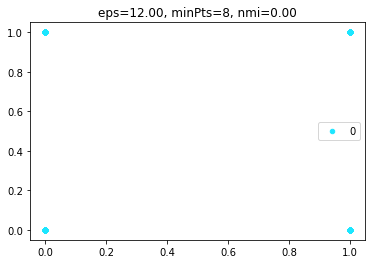

In [83]:
# DBSCAN applied to x
np.random.seed(123)

X = x
ytrue = y

eps = 12
min_sample = 8

# DBSCAN
model = DBSCAN(eps=eps, min_samples=min_sample, metric='l1')
model.fit(X)
ypred = model.labels_
nmi = NMI(ypred, ytrue)

#plot
print('True labels =\n',ytrue)
print('Predicted labels =\n',ypred)
plotting(X,ypred,s=20)

It's clear that in this case DBSCAN cannot be directly applied to the dataset that is made of the samples that are sequences of 0 and 1: the algorithm predicts (with these parameters) all the labels equal to 0.\
For this reason we tried to apply the PCA to the original dataset, keeping all the 36 dimensions.

### DBSCAN applied to x_pca (36-dim)

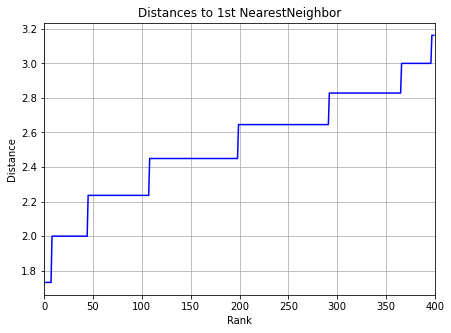

In [63]:
X1 = x_pca
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X1)
distances, indices = nbrs.kneighbors(X1)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(7,5))
plt.title('Distances to 1st NearestNeighbor')
plt.xlabel('Rank')
plt.ylabel('Distance')
plt.plot(distances,'b')
plt.xlim(0,400)
plt.grid()
plt.show()

<ipython-input-8-ee09e9828995>:36: RuntimeWarning: invalid value encountered in double_scalars
  return 2*Iwc/(Hc+Hw)
<ipython-input-8-ee09e9828995>:36: RuntimeWarning: invalid value encountered in double_scalars
  return 2*Iwc/(Hc+Hw)
<ipython-input-8-ee09e9828995>:36: RuntimeWarning: invalid value encountered in double_scalars
  return 2*Iwc/(Hc+Hw)
<ipython-input-8-ee09e9828995>:36: RuntimeWarning: invalid value encountered in double_scalars
  return 2*Iwc/(Hc+Hw)
<ipython-input-8-ee09e9828995>:36: RuntimeWarning: invalid value encountered in double_scalars
  return 2*Iwc/(Hc+Hw)
<ipython-input-8-ee09e9828995>:36: RuntimeWarning: invalid value encountered in double_scalars
  return 2*Iwc/(Hc+Hw)
<ipython-input-8-ee09e9828995>:36: RuntimeWarning: invalid value encountered in double_scalars
  return 2*Iwc/(Hc+Hw)
<ipython-input-8-ee09e9828995>:36: RuntimeWarning: invalid value encountered in double_scalars
  return 2*Iwc/(Hc+Hw)
<ipython-input-8-ee09e9828995>:36: RuntimeWarning: inval

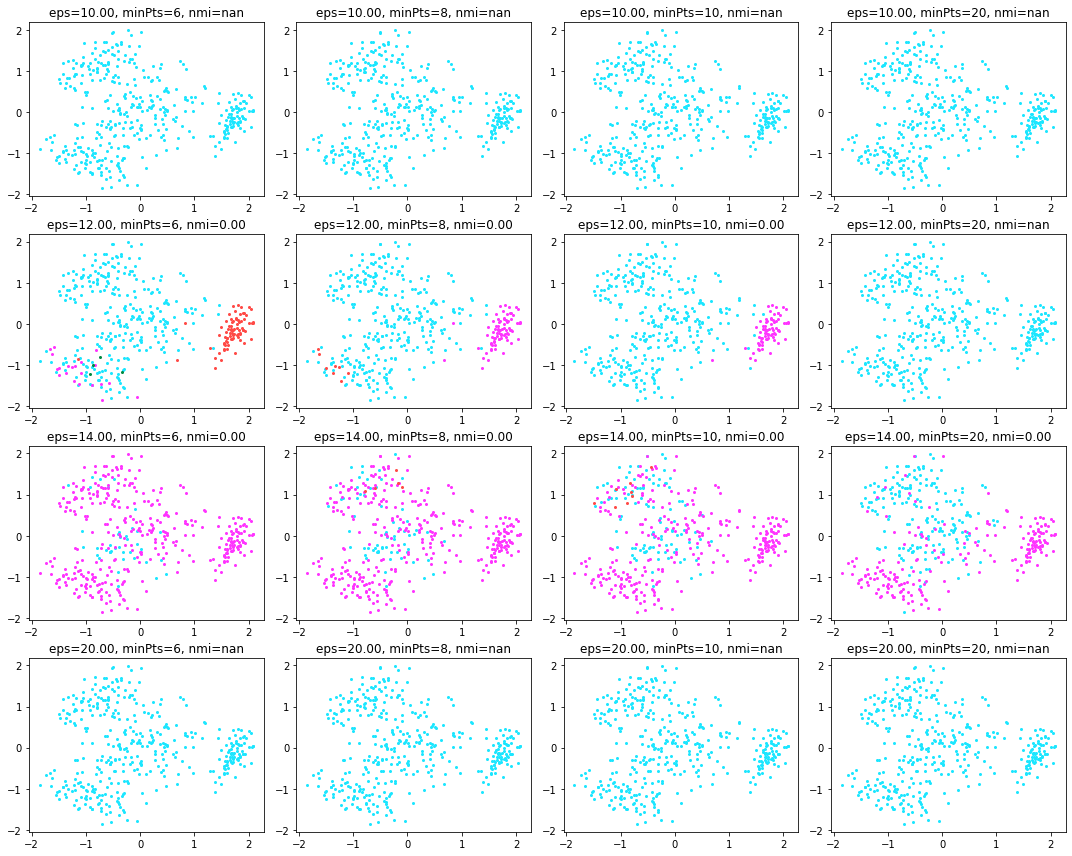

In [70]:
# DBSCAN applied to x
np.random.seed(123)

X = x_pca
ytrue = y

eps_range = [10,12,14,20]
min_sample_range = [6,8,10,20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,12))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples,metric='manhattan')
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi = NMI(y, ytrue)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()

We can see that in this case DBSCAN doesn't perform properly, it labels only a few points correctly.

So (PCA + t-SNE) performs better than (PCA + DBSCAN) in grouping the clusters: this can be due to the fact that the data are very close in the original 36dim space and DBSCAN is not able to 'separate' enough them and to assign them to different clusters (as shown in the plots above).

Now we try DBSCAN on the data projected into 2 dimensions by the t-SNE, to see if DBSCAN works better.

### DBSCAN applied to the data projected by t-SNE (2-dim)

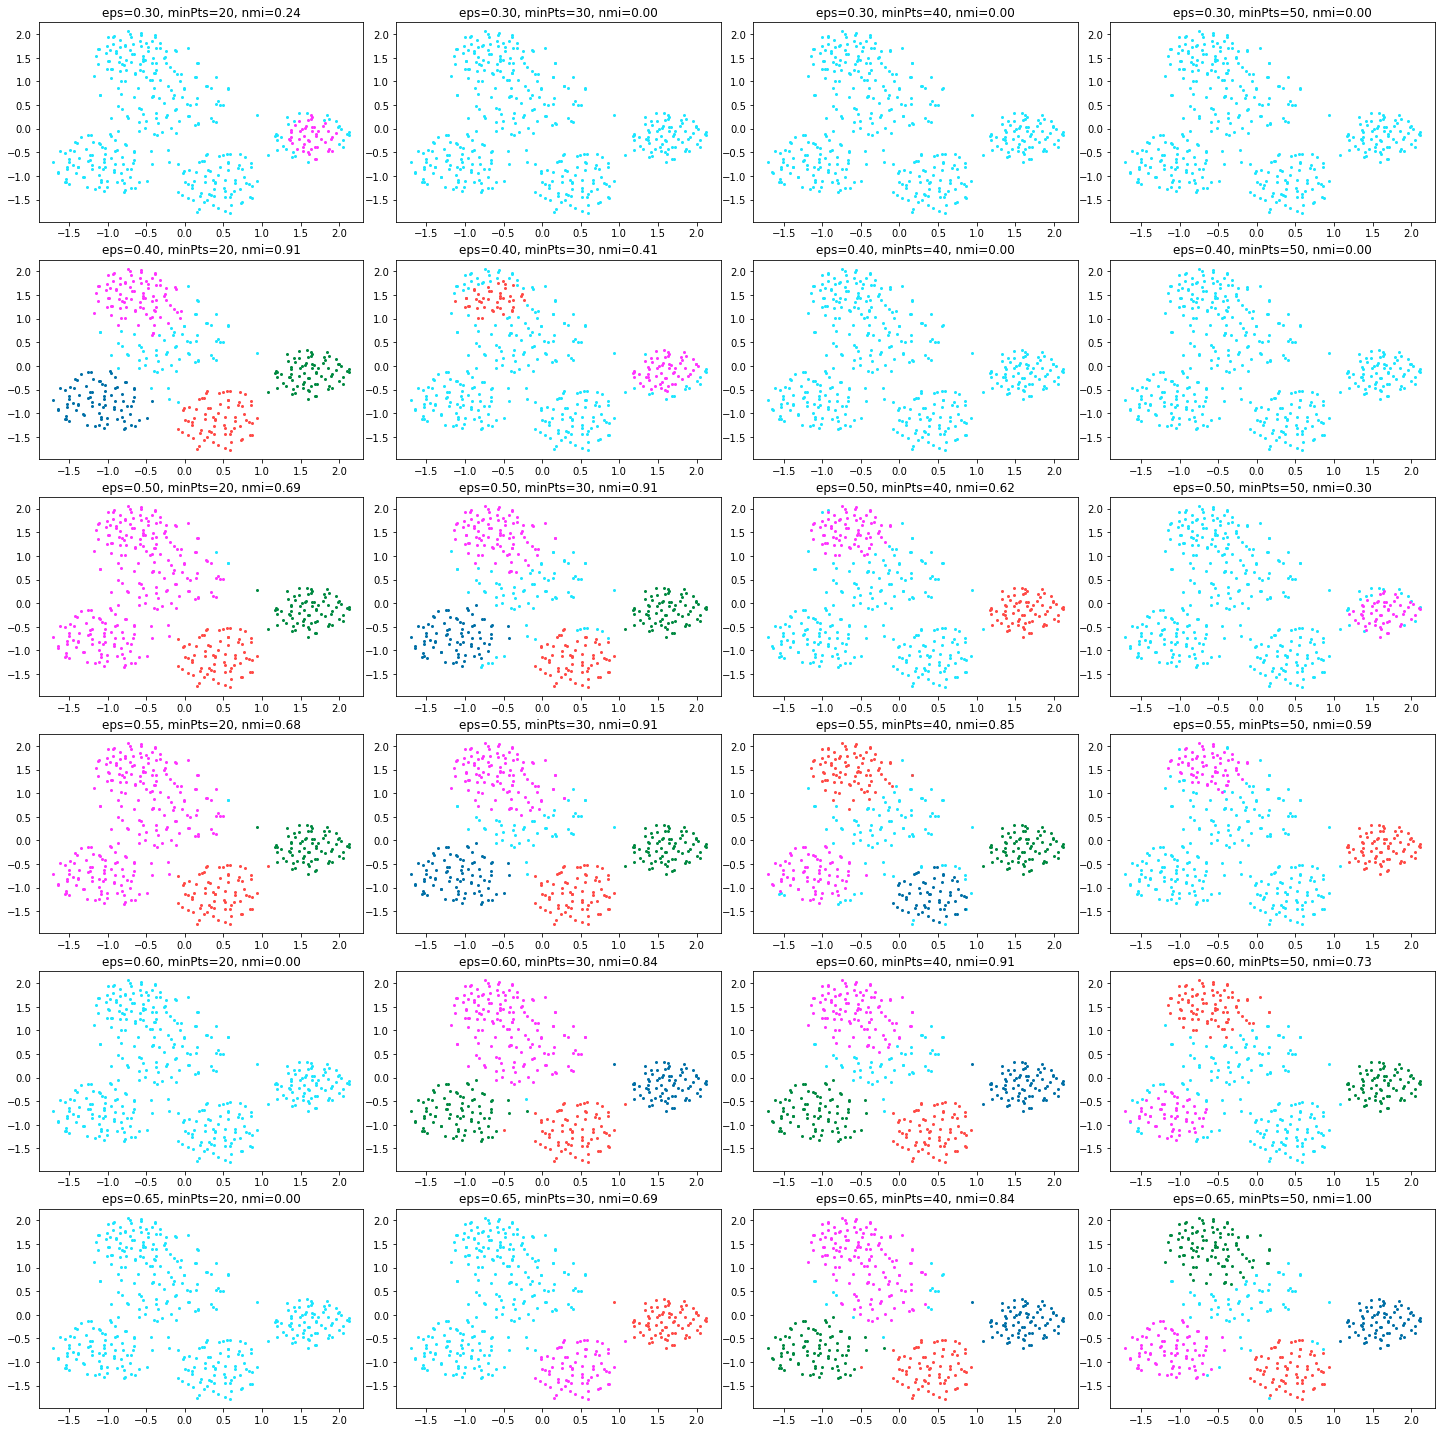

In [72]:
# DBSCAN applied to x_t
np.random.seed(123)

x_t = manifold.TSNE(n_components=2, perplexity=50, random_state=123).fit_transform(x)
X = StandardScaler().fit_transform(x_t)    
ytrue = y

eps_range = [0.3,0.4,0.5,0.55,0.6,0.65]
min_sample_range = [20,30,40,50]

fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(20,20))

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples,metric='l1')
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi = NMI(y, ytrue)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()

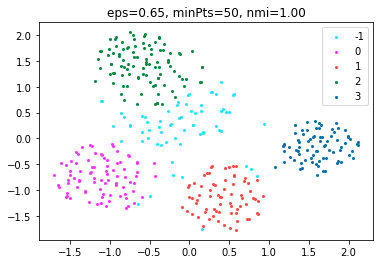

In [24]:
# plot the best result
# best params
eps = 0.65
min_sample = 50

# t_SNE data
X = StandardScaler().fit_transform(x_t)    
ytrue = y

# DBSCAN
model = DBSCAN(eps=0.65, min_samples=50,metric='l1')
model.fit(X)
ypred = model.labels_
nmi = NMI(ypred, ytrue)

#plot
plotting(X,ypred)

This plot shows the best subdivision into cluster that DBSCAN was able to perform. In the legend the points with label = -1 are considered as noise by DBSCAN but in our case they are an actual cluster, the one with label = 4. 

DBSCAN applied to the data projected to 2D by t-SNE works better than normal DBSCAN applied the 36-dimensional bit data (or PCA data). In this case the algorithm can reach $nmi=1$.